## Машинное обучение в бизнесе
### Урок 3. Связь бизнес-показателей и DS-метрик

1. обучить несколько разных моделей на наборе данных ССЗ (train_case2.csv): логрег, бустинг, лес и т.д - на ваш выбор 2-3 варианта
2. при обучении моделей обязательно использовать кроссвалидацию
3. вывести сравнение полученных моделей по основным метрикам классификации: pr/rec/auc/f_score (можно в виде таблицы, где строки - модели, а столбцы - метрики)
4. сделать выводы о том, какая модель справилась с задачей лучше других
5. (опциональный вопрос) какая метрика (precision_recall_curve или roc_auc_curve) больше подходит в случае сильного дисбаланса классов? (когда объектов одного из классов намного больше чем другого).


In [12]:
# Импорты
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import metrics
import itertools
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline, FeatureUnion, make_pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import cross_val_score, train_test_split

from sklearn.linear_model import LogisticRegression
from catboost import CatBoostClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

%matplotlib inline

In [13]:
df = pd.read_csv('./train_case2.csv', sep=';')
df.head()

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,2,18857,1,165,64.0,130,70,3,1,0,0,0,1
3,3,17623,2,169,82.0,150,100,1,1,0,0,1,1
4,4,17474,1,156,56.0,100,60,1,1,0,0,0,0


In [14]:
df.describe()

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
count,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000
mean,49972.419900,19468.865814,1.349571,164.359229,74.205690,128.817286,96.630414,1.366871,1.226457,0.088129,0.053771,0.803729,0.499700
std,28851.302323,2467.251667,0.476838,8.210126,14.395757,154.011419,188.472530,0.680250,0.572270,0.283484,0.225568,0.397179,0.500003
min,0.000000,10798.000000,1.000000,55.000000,10.000000,-150.000000,-70.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,25006.750000,17664.000000,1.000000,159.000000,65.000000,120.000000,80.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000
50%,50001.500000,19703.000000,1.000000,165.000000,72.000000,120.000000,80.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000
75%,74889.250000,21327.000000,2.000000,170.000000,82.000000,140.000000,90.000000,2.000000,1.000000,0.000000,0.000000,1.000000,1.000000
max,99999.000000,23713.000000,2.000000,250.000000,200.000000,16020.000000,11000.000000,3.000000,3.000000,1.000000,1.000000,1.000000,1.000000


In [15]:
df['cholesterol'].unique()

array([1, 3, 2])

array([[<AxesSubplot:title={'center':'age'}>,
        <AxesSubplot:title={'center':'height'}>],
       [<AxesSubplot:title={'center':'weight'}>, <AxesSubplot:>]],
      dtype=object)

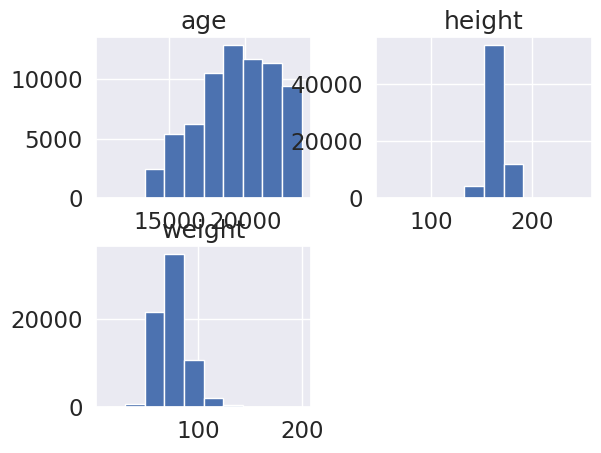

In [16]:
df[['age','height','weight']].hist()

In [17]:
X = df.drop('cardio', axis=1)
y = df['cardio']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [29]:
class ColumnSelector(BaseEstimator, TransformerMixin):
    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[self.key]

class NumberSelector(BaseEstimator, TransformerMixin):
    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[[self.key]]

class AbsNumberSelector(ColumnSelector):
    def transform(self, X):
        return abs(X[[self.key]])

class OHEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, key):
        self.key = key
        self.columns = []

    def fit(self, X, y=None):
        self.columns = [col for col in pd.get_dummies(X, prefix=self.key).columns]
        return self

    def transform(self, X):
        X = pd.get_dummies(X, prefix=self.key)
        test_columns = [col for col in X.columns]
        for col_ in test_columns:
            if col_ not in self.columns:
                X[col_] = 0
        return X[self.columns]

In [52]:
to_scaled_cols = ('age', 'height', 'weight','ap_hi', 'ap_lo',)
# cat_cols = ('gender', 'cholesterol',)
# other_cols = ('gluc', 'smoke', 'alco', 'active',)
other_cols = ('gluc', 'smoke', 'alco', 'active', 'gender', 'cholesterol',)
abs_cols = ('ap_hi', 'ap_lo', )

transformers = []

for _col in to_scaled_cols:
    transformers.append((_col, Pipeline([
                ('selector', NumberSelector(key=_col)),
                ('standard', StandardScaler())
            ])))

# for _col in cat_cols:
#     transformers.append((_col, Pipeline([
#                 ('selector', NumberSelector(key=_col)),
#                 ('ohe', OHEncoder(key=_col))
#             ])))

# for _col in abs_cols:
#     transformers.append((_col, Pipeline([
#                 ('selector', AbsNumberSelector(key=_col)),
#                 ('standard', StandardScaler())
#             ])))

for _col in other_cols:
    transformers.append((_col, Pipeline([
                ('selector', NumberSelector(key=_col))
            ])))

feats = FeatureUnion(transformers)

In [44]:
metrics_ = []

========== LogisticRegression ==========
CV score is 0.7817470170825431+-0.009738840865269995
Best Threshold=0.390812, F-Score=0.735, Precision=0.649, Recall=0.846, ROC_AUC=0.785


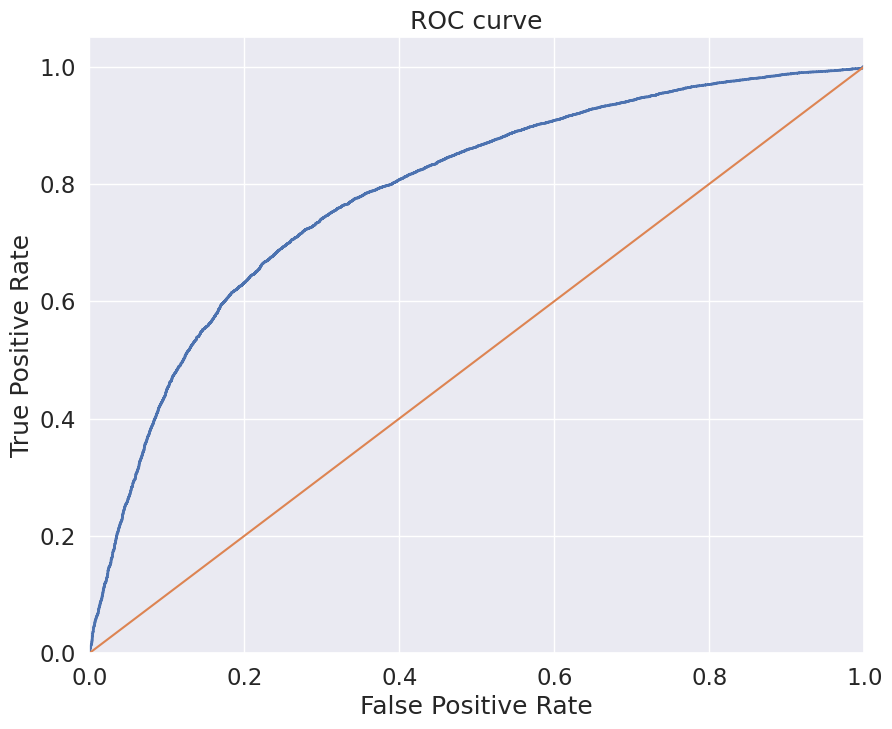

========== RandomForestClassifier ==========
CV score is 0.7758151445555985+-0.007994458809191089
Best Threshold=0.370000, F-Score=0.724, Precision=0.654, Recall=0.811, ROC_AUC=0.774


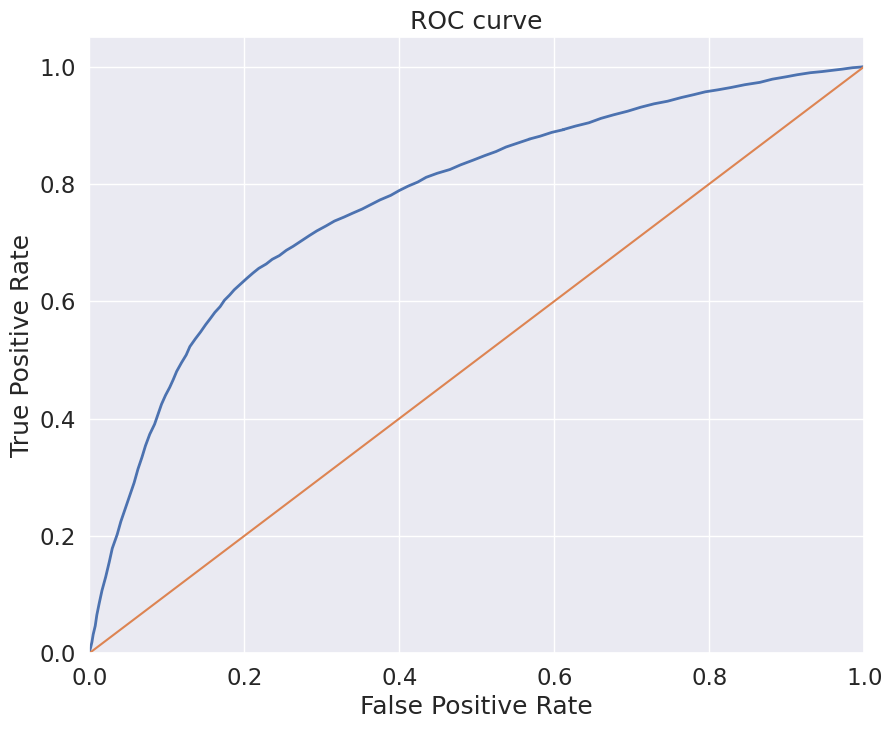

========== GradientBoostingClassifier ==========
CV score is 0.8021970814405218+-0.008872632538430155
Best Threshold=0.410948, F-Score=0.746, Precision=0.716, Recall=0.780, ROC_AUC=0.803


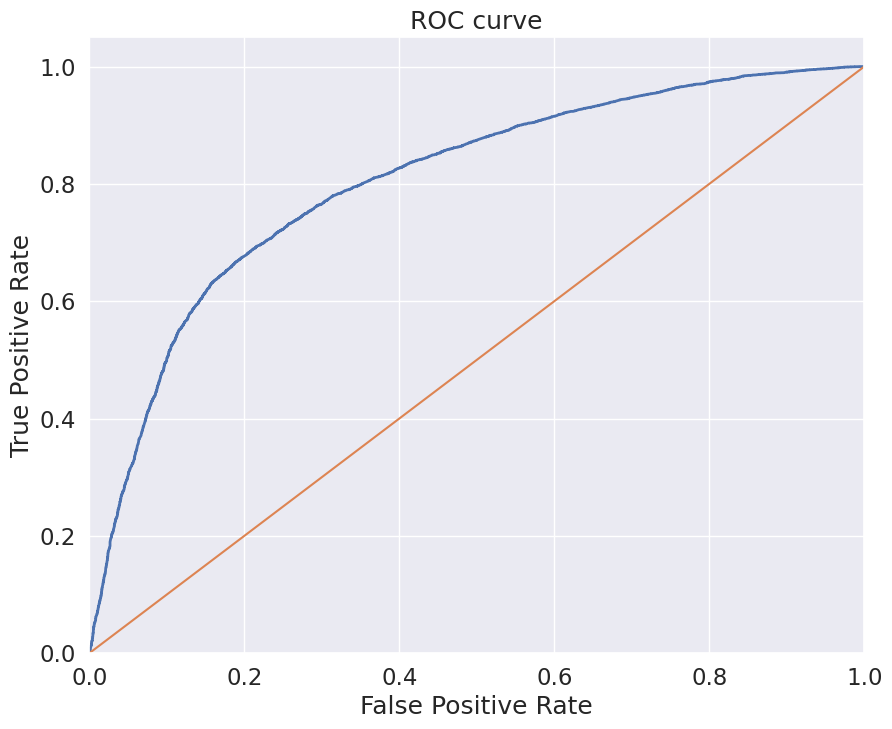

In [49]:
for model in (
    LogisticRegression(random_state=41),
    RandomForestClassifier(random_state=41),
    # CatBoostClassifier(),
    GradientBoostingClassifier(random_state=41)
):
    print('='*10,model.__class__.__name__,'='*10)
    classifier = Pipeline([
        ('features',feats),
        ('classifier', model),
    ])
    cv_scores = cross_val_score(classifier, X_train, y_train, cv=16, scoring='roc_auc')
    cv_score = np.mean(cv_scores)
    cv_score_std = np.std(cv_scores)
    print('CV score is {}+-{}'.format(cv_score, cv_score_std))
    classifier.fit(X_train, y_train)
    y_score = classifier.predict_proba(X_test)[:, 1]

    b=1
    precision, recall, thresholds = metrics.precision_recall_curve(y_test.values, y_score)
    fscore = (1+b**2)*(precision * recall) / (b**2*precision + recall)
    # locate the index of the largest f score
    ix = np.argmax(fscore)
    roc_auc_score_ = metrics.roc_auc_score(y_test, y_score)
    print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f, ROC_AUC=%.3f' % (thresholds[ix],
                                                                            fscore[ix],
                                                                            precision[ix],
                                                                            recall[ix],
                                                                            roc_auc_score_
                                                                           ))
    metrics_.append([
        model.__class__.__name__,
        thresholds[ix],
        fscore[ix],
        precision[ix],
        recall[ix],
        roc_auc_score_
    ])
    sns.set(font_scale=1.5)
    sns.set_color_codes("muted")

    plt.figure(figsize=(10, 8))
    fpr, tpr, thresholds_ = metrics.roc_curve(y_test, y_score, pos_label=1)
    lw = 2
    plt.plot(fpr, tpr, lw=lw, label='ROC curve ')
    plt.plot([0, 1], [0, 1])
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC curve')
    plt.show()


In [47]:
pd.DataFrame(metrics_,
             columns=('classifier', 'thresholds', 'fscore', 'precision', 'recall', 'roc_auc'))

,classifier,thresholds,fscore,precision,recall,roc_auc
0,LogisticRegression,0.390812,0.734585,0.649299,0.845665,0.784793
1,RandomForestClassifier,0.370000,0.724390,0.654311,0.811280,0.773983
2,GradientBoostingClassifier,0.410948,0.746389,0.715684,0.779846,0.803264


#### Выводы
В рамках выполнения практической работы были проверенны 3 модели. Немного лучший результат показала модель градиентного бустинга. Но без тюнинга гиперпараметров и более детального разбора датасета сложно дать однозначный ответ